# **Projekt: Fehlererkennung in Getrieben**
## **Netztyp 2: FFT-Net**


Mey et al. (2020) untersuchten die automatisierte Erkennung von Unwuchten in rotierenden Wellen mithilfe von Maschinellem Lernen und veröffentlichten hierfür einen spezifischen Datensatz. In diesem Kontext entwickeln und analysieren sie vier Klassifizierungsalgorithmen: Convolutional Neural Network (CNN), Fully-Connected Neural Network (FCNN), Hidden Markov Model und Random Forest. Diese Algorithmen unterscheiden zwischen den Zuständen "eine Unwucht liegt vor" und "keine Unwucht liegt vor". Das FCNN erreicht hier, als die erfolgreichste Methode, eine Vorhersagegenauigkeit von 98,5 %. <br>
Das vorliegende Projekt reproduziert zunächst das von Mey et al. beschriebene CNN. Auf Basis des FCNNs wird zudem ein Neuronales Netzwerk (NN) entwickelt, das eine Unterscheidung der, im Datensatz angegebenen, fünf Unwucht-Stufen leisten kann. Das CNN verarbeitet hierbei direkt Sensordaten. Für das FCNN überführt die Fast
Fourier Transform (FFT) die Daten vorab in den Frequenzbereich. <br>
Im Rahmen des Projektes sind so mehrere Python Module entstanden. Der vollständige Code ist in einem GitHub Repository (Kuhlen et al., 2024) verfügbar.


### **Teil A: Preprocessing**

Mey et al. (2020) beschreiben ausschließlich die wesentlichen Schritte der Datenaufbereitung, dem Preprocesing. Ihre Ausführungen werden um Funktionalitäten ergänzt. Deren Notwendigkeit ist an entsprechender Stelle begründet.

> **Abkürzungsverzeichnis**
> | Abkürzung | Bedeutung |
> |:----------|:----------|
> | CNN | Convolutional Neural Network |
> | CSV | Comma-Separated Values |
> | FCNN | Fully Connected Neural Network |
> | FFT | Fast Fourier Transform |
> | IQR | Inter-Quantile Range, Interquantilabstand |
> | NN | Neural Network, Neuronales Netzwerk |
> | UUID | Universally Unique Identifier |
> | YAML | Yet Another Markdown Language |
>
> <br>

#### **Die Projektstruktur**
Das FFT-Net gliedert sich in die zwei Jupyter Notebooks *fft_net_preprocessing.ipynb* und *fft_net.ipynb*. Die *fft_net_preprocessing.ipynb* umfasst den Download des Datensatzes und das eigentliche Preprocessing. Die aufbereiteten Daten greift die *fft_net.ipynb* auf. Sie erstellt, trainiert und bewertet das NN. Im Projekt finden sich diese Skripte im Ordner *working_dir/notebooks/*. Auf die Nennung des Working Directories *working_dir* wird in nachfolgenden Dateipfaden verzichtet. <br>
Auf dem Pfad *src/* befinden sich die vier Python-Skripte *data_loading.py*, *input_preparation.py*, *model_construction.py*, *preprocessing.py* und *visualization.py*. Jedes Modul umfasst Funktionen für einen spezifischen Prozessschritt hin zu einem funktionsfähigen NN. Sie sind im Folgenden in chronologischer Reihenfolge beschrieben. <br>
Das Modul `data_loading` umfasst Funktionen zum Herunterladen des Kaggle-Datensatzes, sowie zum Laden und Speichern von Datensätzen aus der und in die Projekt-Ordnerstruktur. Im Modul `preprocessing` sind alle Funktionen für die Vorverarbeitung der Daten enthalten. Die Vorbereitung der vom Preprocessing aufbereiteten Daten auf die Eingabe in das Neuronale Netz übernehmen Funktionen aus der `input_preparation`. Das eigentliche NN konstruiert der Constructor aus der `model_construction`. Hier sind zudem weitere Funktionen mit Bezug auf die Architektur und Performance des NNs abgelegt. Das Modul `visualization` bietet Funktionen zur Visualisierung von Daten über den gesamten Prozess.

In [27]:
# import libraries
from uuid import uuid4
import os
from pathlib import Path

# module imports from /src
if Path.cwd().stem == "notebooks":
    os.chdir( Path.cwd().parent)

# custom modules
import src.preprocessing as pre
import src.data_loader as dl
import src.visualization as vis

Zu Beginn des Codes erlauben einige Booleans die Kontrolle des Prozessablaufs. Das Notebook erlaubt die Kontrolle der korrekten Funktionsweise über einen Testbetrieb, der mit der Boolean `TEST` aktiviert wird. Die Boolean `DOWNLOAD` aktiviert den (erneuten) Download des Kaggle Datensatzes. Ist die Visualisierung der Daten im Prozess nicht gewünscht, deaktiviert die Boolean `SHOW` die entsprechenden Funktionen. Über einen hier gesetzten `CONTROL_INDEX` erfolgt im Prozess die stichprobenartige Visualisierung der Daten. An dieser Stelle wird zudem ein Universally Unique Identifier (`UUID`) generiert, der bei der Speicherung der verarbeiteten Daten als Ordnername verwendet wird. <br>

In [28]:
# boolean values to control the program flow
TESTING: bool = True
DOWNLOAD: bool = False
SHOW: bool = True

# setup a single index for control of preprocessing steps
CONTROL_INDEX: int = 4

# generate a unique identifier for this run
UUID: str = str(uuid4())
print(f"Current UUID:\t{UUID}")

Current UUID:	f119d8dd-e258-447e-ad02-968e6619b512


#### **Der Datensatz**

Die Datenerfassung beschreiben Mey et al. (2020) wie folgt. Eine Welle wird von einem Gleichstrommotor angetrieben (vergl. Abb. 1). Sie ist in Richtung des freien Endes in einem Kugellager gelagert. In der Ebene des Kugellagers sitzen zwei Sensoren, die die Vibration der Welle in der Horizontalen und Vertikalen erfassen. Ein dritter Sensor sitzt oberhalb der Einspannung der Welle am Motor. Die Unwucht wird über eine Schwungscheibe am freien Wellenende in das System eingebracht. Auf dieser Scheibe können Schrauben auf verschiedenen Radien montiert werden. <br>
Mey et al. erhöhten pro Messreihe ist die Eingangsspannung beginnend von einem Startwert in festen Intervallen bis ein Endwert erreicht wurde. Die jeweiligen Start- und Endwerte sowie die Intervallgrößen sind bei Mey et al. bzw. in der *data/raw/meta.yaml* nachzulesen. Jeder Spannungswert ist für 10 s gehalten worden. Die erzeugten Rotationsgeschwindigkeiten reichen von rund 630 RPM bis ca. 2330 RPM. <br>
Jede Messreihe ist mit einer Sample Rate von 4096 Hz aufgezeichnet worden. Es wurden insgesamt vier Unwuchtstärken erzeugt. Als Referenz ist eine Messung ohne eingebrachte Unwucht aufgezeichnet worden. Neben den Messungwerten der drei Sensoren ist in jedem Datensatz der Verlauf der Spannung und der Drehzahl enthalten.

In [29]:
if DOWNLOAD:
    
    # download full dataset from kaggle
    dl.fetch_kaggle_dataset(dl.DATASET_ADDRESS)

Sobald der Download des Datensatzes abgeschlossen ist, liegen die CSV Dateien auf dem Pfad *working_dir/data/raw/*. Auf diesem Pfad liegt derweil bereits eine YAML Dateil, die Informationen zu den Aufnahmebedingungen jeder Messreihe enthält. Die Funktion `load_all_datasets()` greift auf den Dateipfad zu und erstellt aus allen CSV Dateien Pandas DataFrames. In deren `DataFrame.attrs` hinterlegt sie die korrespondierenden Informationen der YAML Datei.

In [30]:
if not TESTING:
    
    # load data from folder and split in training and evaluation data
    data_path = Path().cwd() / "data" / "raw"
    development_data, evaluation_data = dl.load_all_datasets(data_path)
    all_datasets = development_data + evaluation_data

else:

    # program testing set
    test = dl.load_dataset(Path("./data/raw/3D.csv"))

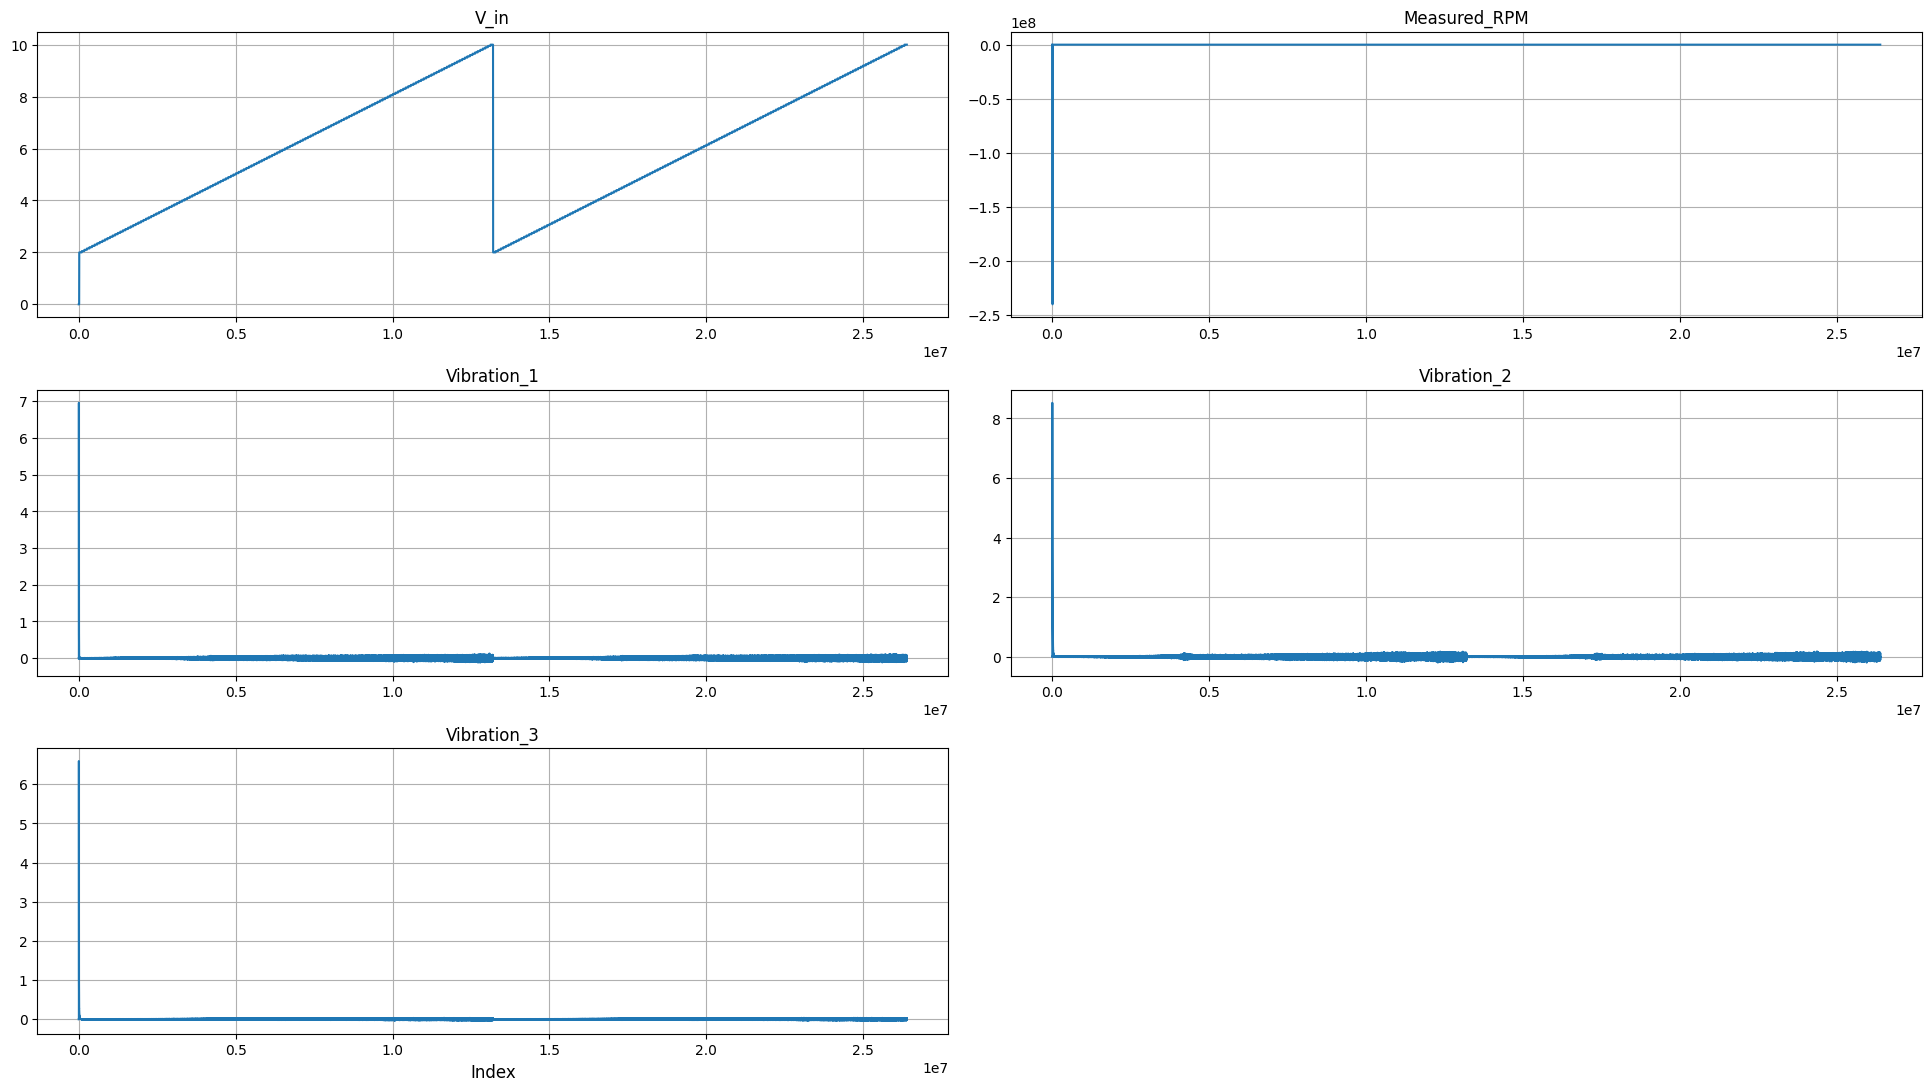

In [31]:
if SHOW:
    if not TESTING:

        for index, dataset in enumerate(all_datasets):
            # visualize one random dataset for data validation
            print(dataset.attrs["path"])
            vis.plot_columns_as_subplots(dataset, dataset.columns)

    else:

        # visualize the program testing set
        vis.plot_columns_as_subplots(test, test.columns)

#### **Die Datenaufbereitung**
##### **Bereinigung der Daten**
Jeder Datensatz zeigt zu Beginn der Sensordaten einen starken positiven Ausschlag. Die ersten rund 12.000 aufgezeichneten Spannungen liegen nicht auf dem Startwert, sondern betragen null. Thresholding entfernt zunächst alle Datenpunkte, die bei 0 V aufgezeichnet wurden. Die erneute Visualisierung der Daten zeigt, dass der positive Ausschlag der Sensordaten so nicht vollständig beseitigt ist. Daher verwirft das Programm weitere ca. 38.000 Zeilen. Damit folgt das Preprocessing den Ausführungen von Mey et al. (2020) und verwirft die ersten 50.000 Messpunkte.

In [32]:
if not TESTING:

    for index, dataset in enumerate(all_datasets):
        pre.apply_threshold(
            dataframe=dataset,
            threshold=0,
            column="V_in",
            mode="eq",
            copy=False,
            reset_index=False,
        )
        dataset = pre.discard_data(
            dataframe=dataset, start=None, end=50_000, reset_index=True
        )

else:

    pre.apply_threshold(
        dataframe=test,
        threshold=0,
        column="V_in",
        mode="eq",
        copy=False,
        reset_index=False,
    )
    test = pre.discard_data(dataframe=test, start=None, end=50_000, reset_index=True)

apply_threshold():
	12288 rows discarded.

discard_data():
	Limits interpreted as indices.
	37712 rows discarded.


Anhand des Verlaufs der Eingangsspannung erfolgt die Zerlegung eines jeden DataFrames in die jeweiligen beiden Messzyklen. Als Schnittpunkte dienen hierbei die negativen Gradienten in den Spannungen. Bei diesem Prozess entstehen z. T. kurze Residualelemente, die für die weitere Bearbeitung entfernt werden. In den `DataFrame.attrs` wird dem Dateinamen eine Laufnummer mit vorangestelltem Unterstrich angehangen.

In [33]:
if not TESTING:

    measurement_cycles = []

    for index, dataset in enumerate(all_datasets):
        subsets = pre.split_by_gradient_direction(
            dataframe=dataset,
            column="V_in",
            periods=1,
            sign=-1,
            min_length=50_000,
            reset_index=True,
        )
        for subset in subsets:
            measurement_cycles.append(subset)

else:

    test_measurement_cycles = pre.split_by_gradient_direction(
        dataframe=test,
        column="V_in",
        periods=1,
        sign=-1,
        min_length=50_000,
        reset_index=True,
    )

data\raw\3D_0.csv


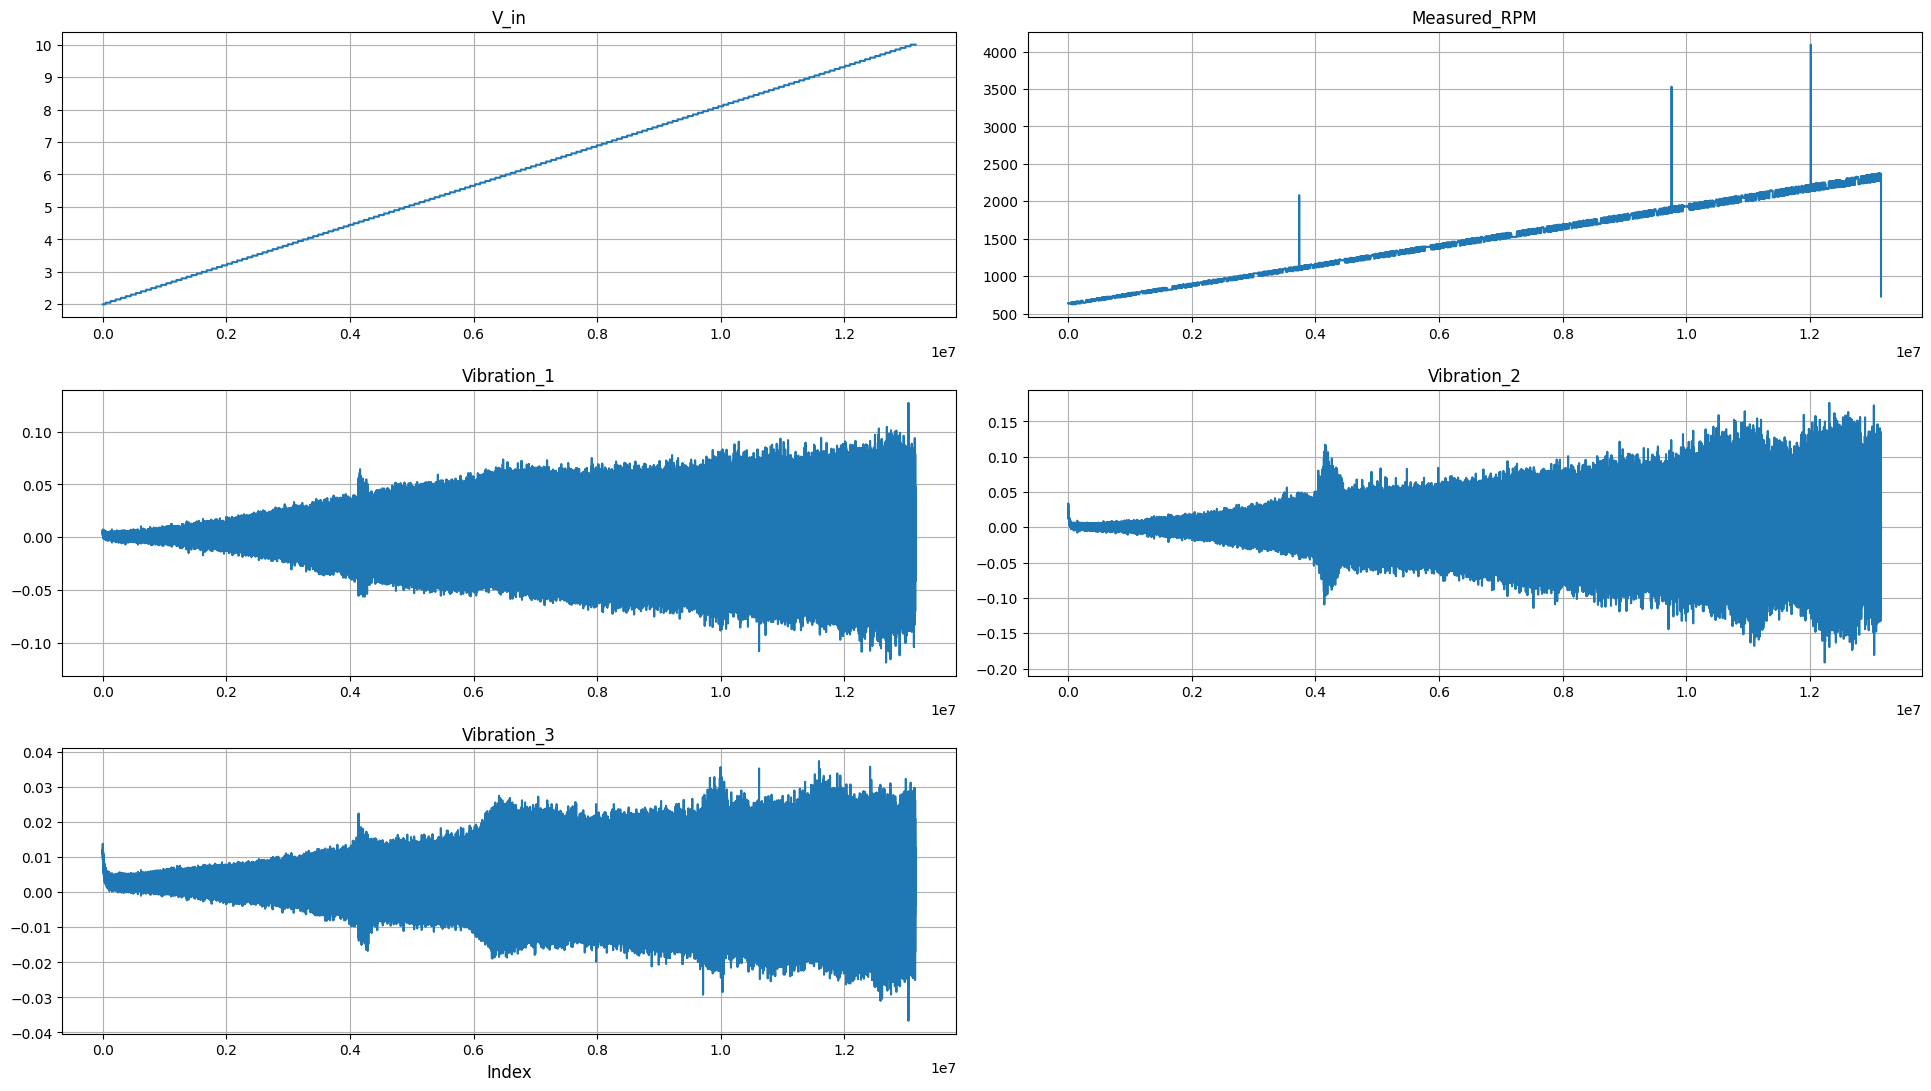

data\raw\3D_1.csv


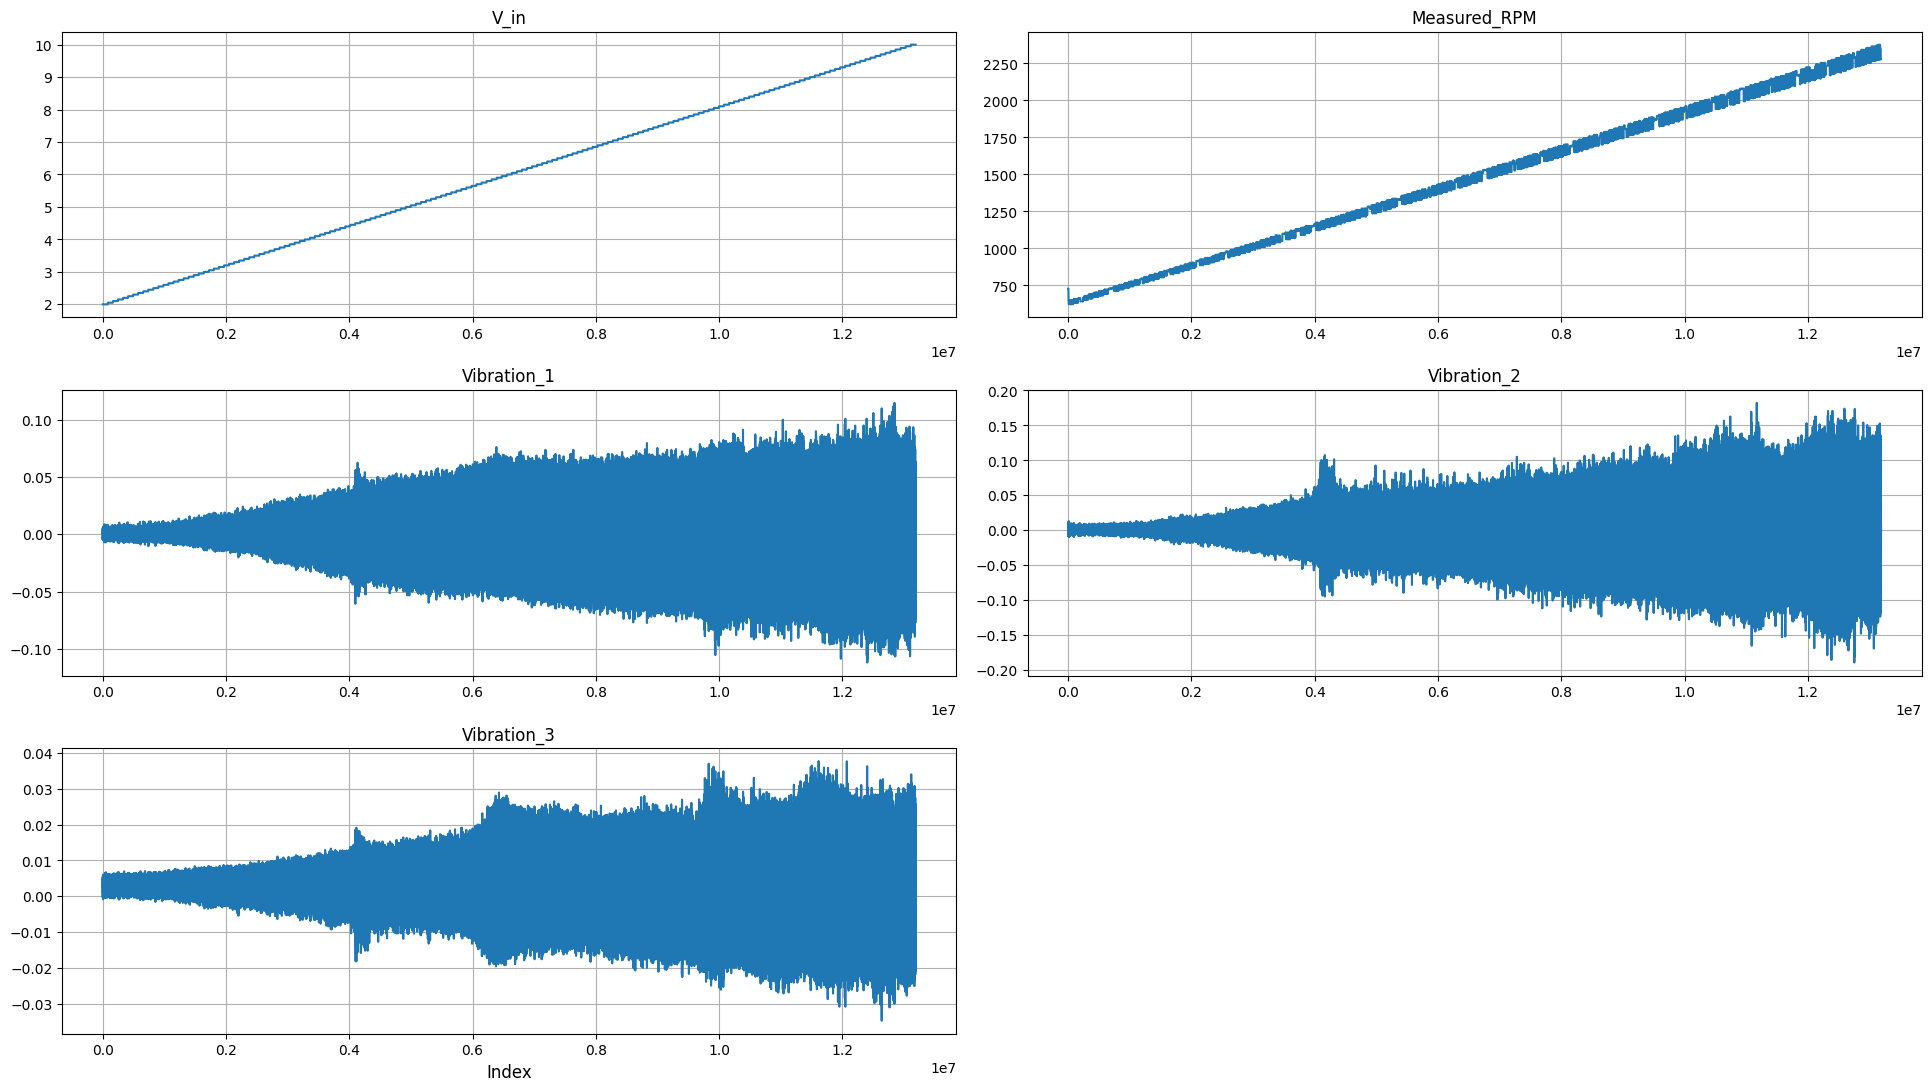

In [34]:
if SHOW:
    if not TESTING:

        # visualize one random dataset for data validation
        for dataset in measurement_cycles:
            print(dataset.attrs["path"])
            vis.plot_columns_as_subplots(dataset,
                                        dataset.columns)

        
    else:
        for dataset in test_measurement_cycles:
            # visualize the program testing set
            print(dataset.attrs["path"])
            vis.plot_columns_as_subplots(dataset, dataset.columns)

In den Messungen der Drehzahlen zeigen sich Ausreißer.

In [35]:
if not TESTING:

    for index, dataset in enumerate(measurement_cycles):
        # calculate fft frequencies and magnitudes alongside the median rpms
        clean_data = pre.clean_outliers(
            dataframe=dataset,
            column_name="Measured_RPM",
            window_size=None,
            std_multiplier=2,
            discard=True,
        )
        measurement_cycles[index] = clean_data

else:

    for index, dataset in enumerate(test_measurement_cycles):
        clean_data = pre.clean_outliers(
            dataframe=dataset,
            column_name="Measured_RPM",
            window_size=None,
            std_multiplier=3,
            discard=True,
        )
        test_measurement_cycles[index] = clean_data

clean_outliers():
13151408
(12289,)
(12289,)
clean_outliers():
13186497
(4095,)
(4095,)


data\raw\3D_0.csv


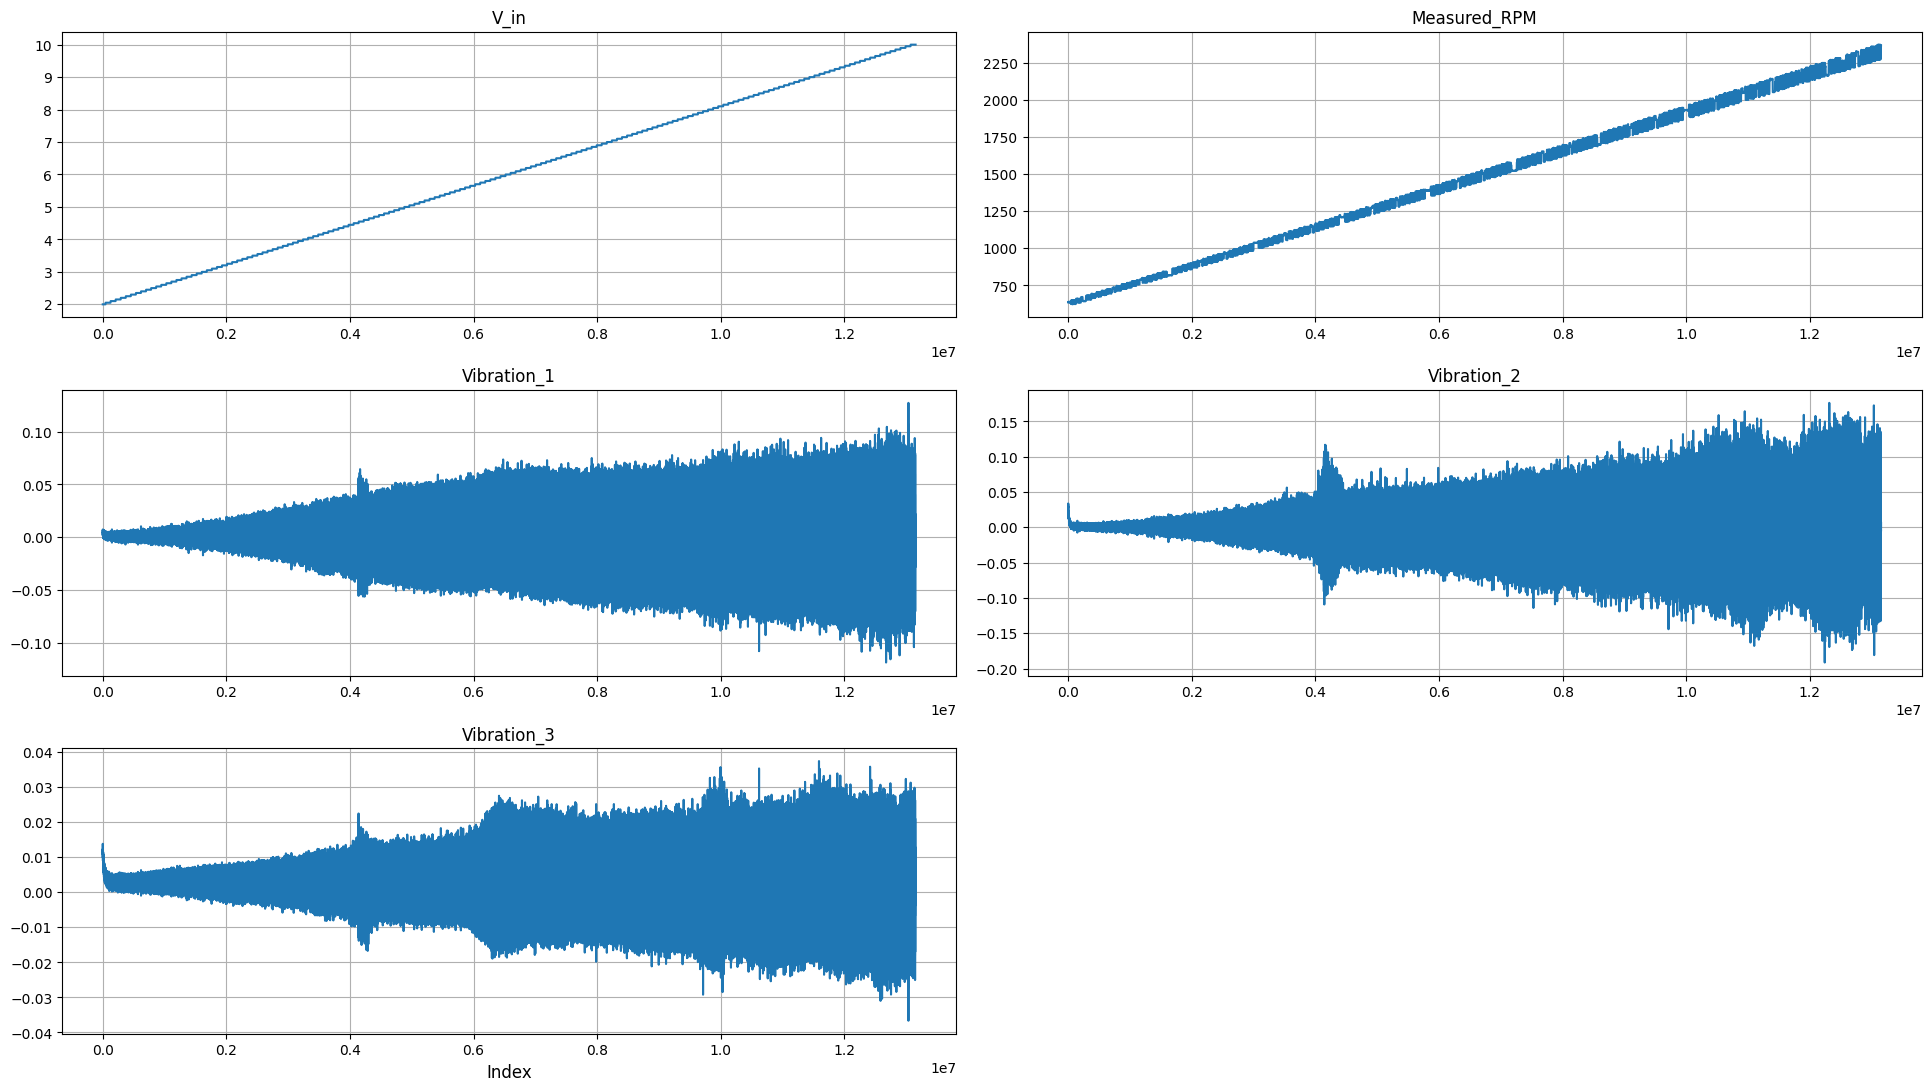

data\raw\3D_1.csv


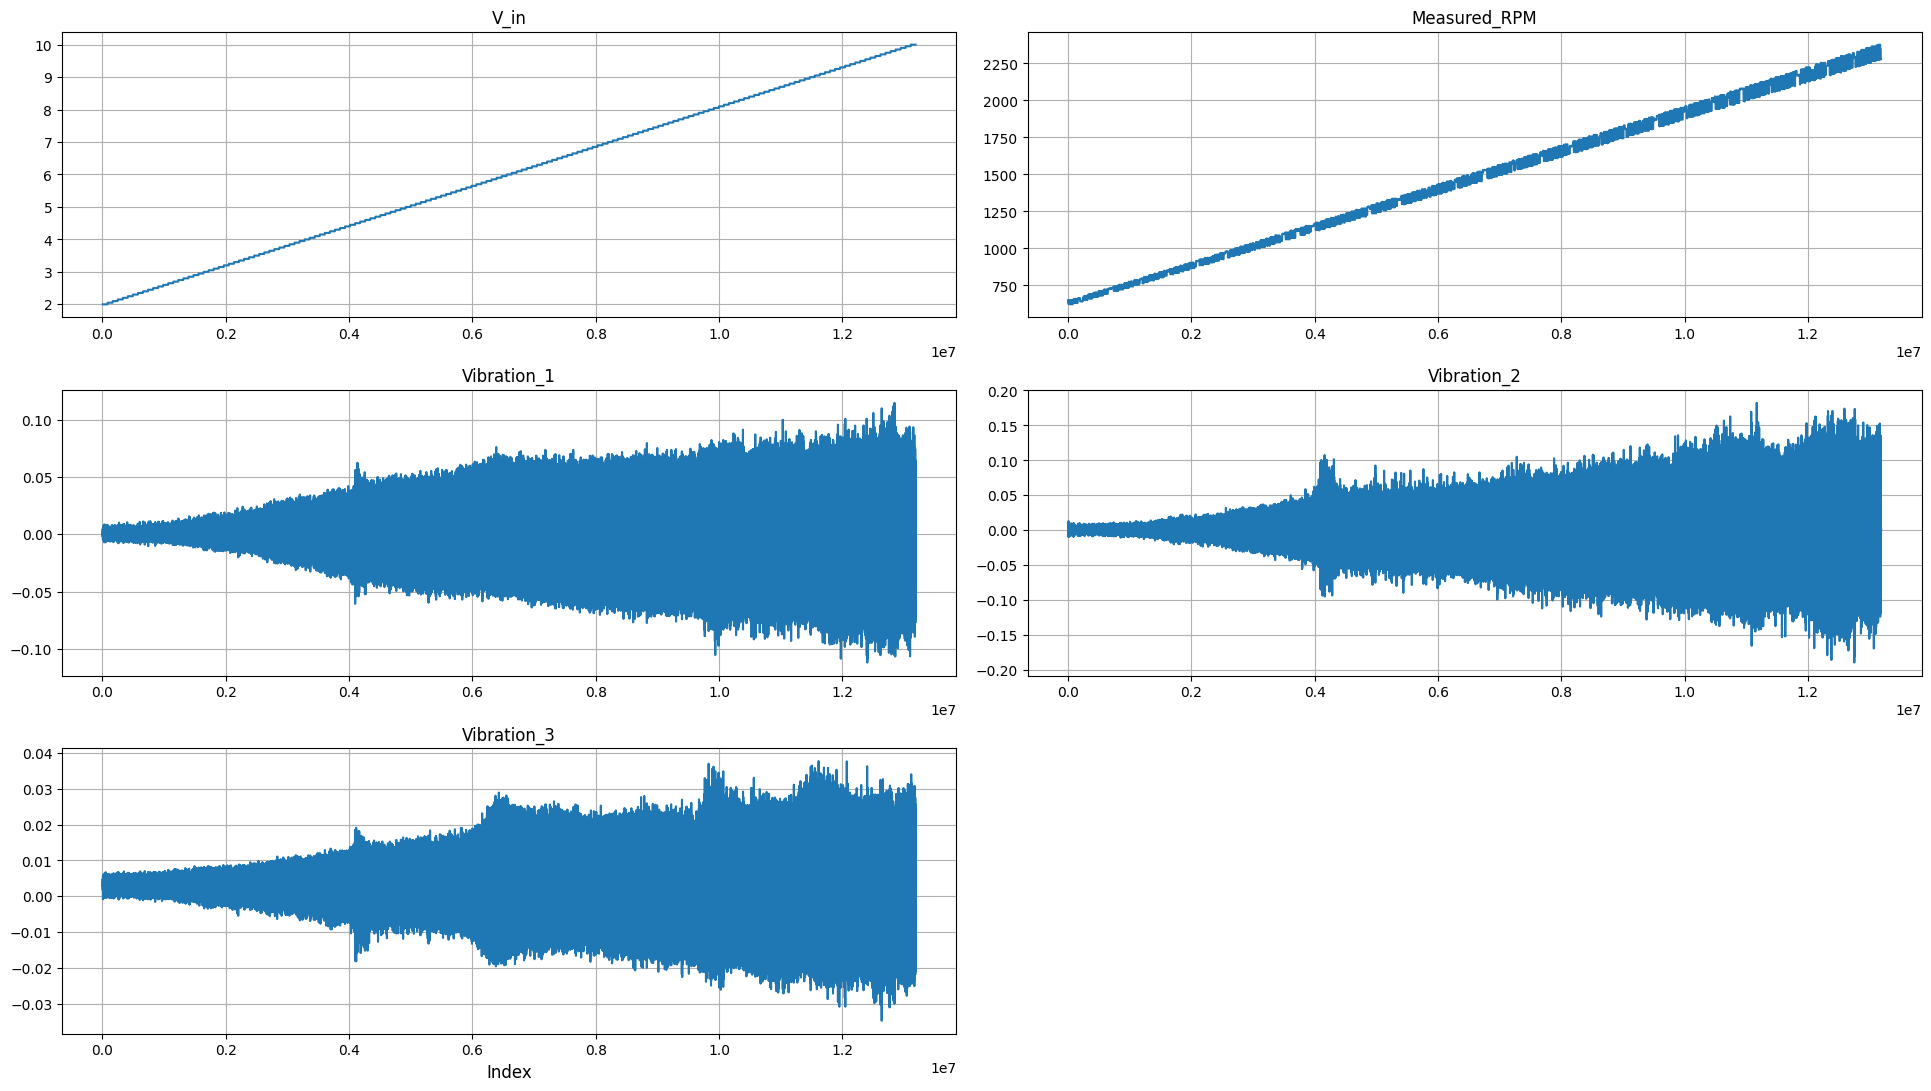

In [36]:
if SHOW:
    if not TESTING:

        # visualize one random dataset for data validation
        for dataset in measurement_cycles:
            print(dataset.attrs["path"])
            vis.plot_columns_as_subplots(dataset,
                                        dataset.columns)

        
    else:
        for dataset in test_measurement_cycles:
            # visualize the program testing set
            print(dataset.attrs["path"])
            vis.plot_columns_as_subplots(dataset, dataset.columns)

##### **Datentransformation**
Das FCNN von Mey et al. verarbeitet die Sensordaten von Sensor Nr. 1. Diese werden vorab in den Frequenzraum überführt. Hierbei werden jeweils die Datenmenge einer Sekunde &mdash; $n=4096$ Messwerte &mdash; fourier-transformiert und die jeweils 2048 physikalisch relevanten Fourier-Koeffizienten weiterverwendet (Mey et al., 2020, Abschnitt B). <br>
NumPy (Harris et al., 2020) bietet zur Berechnung der positiven Frequenzanteile die Funktion `numpy.rfft()`, die in diesem Projekt implementiert ist. Sie löst Gleichung 1 für reelles Eingabesignal mit den Messwerten $a_m$. 

$$A_k = \frac{1}{n} \cdot \sum^{n-1}_{m=0} a_m \cdot e^{-2\,\pi\,i\,\frac{m\,k}{n}} \qquad \text{mit} \quad k = 0,~\dots,~n-1 \qquad \qquad (1)$$

Pro Sekunde des ursprünglichen Datensatzes gibt die `numpy.rfft()` 2049 realwertige Fourier-Koeffizienten $A_k$. Das erste Element bildet den sog. "Zero Frequency Term", die Summe des gesamten Signals. Dieser Term wird verworfen. Die übrigen 2048 Werte bilden die Eingabe für das NN. <br>
Das gesamte Eingangssignal wird fourier-transformiert, wobei sich die Fenster nicht überlagern. Aufgrund der Halbierung der Anzahl von Messwerten, speichert ein neues Dataset die transformierten Daten. Für eine spätere Zuordnung wird mit derselben Fenstergröße der Median der Drehzahlen berechnet. Der neue Datensatz erhält eine Kopie der `DataFrame.attrs` des ursprünglichen Datensatzes. Den ursprünglichen Dateinamen ergänzt ein Suffix "_fft". Der Eintrag "sample_rate" wird auf 2048 Hz gesetzt.

In [37]:
if not TESTING:

    for index, dataset in enumerate(measurement_cycles):
        # calculate fft frequencies and magnitudes alongside the median rpms
        fft_dataset = pre.calculate_fft_magnitudes(
            dataset,
            column_name=["Vibration_1", "Vibration_2", "Vibration_3"],
            normalize=False,
        )
        rpms = pre.median(dataset, column="Measured_RPM", stretch=True)
        fft_dataset["rpm"] = rpms[::2]
        measurement_cycles[index] = fft_dataset

else:
    
    for index, dataset in enumerate(test_measurement_cycles):
        fft_data = pre.calculate_fft_magnitudes(dataset, column_name="Vibration_*", normalize=False)
        rpms = pre.median(dataset, column="Measured_RPM", stretch=True)
        fft_data["rpm"] = rpms[::2]
        test_measurement_cycles[index] = fft_data

,fft_frequency,vibration_1_magnitude,vibration_2_magnitude,vibration_3_magnitude,rpm
count,6.567936e+06,6.567936e+06,6.567936e+06,6.567936e+06,6.567936e+06
mean,1.024500e+03,3.432798e-01,4.513599e-01,1.227413e-01,1.477738e+03
std,5.912067e+02,6.071080e-01,7.072846e-01,2.155093e-01,4.913676e+02
min,1.000000e+00,2.382846e-06,2.385121e-06,1.193560e-06,6.283271e+02
25%,5.127500e+02,3.515796e-02,3.602584e-02,2.250157e-02,1.051097e+03
50%,1.024500e+03,1.209297e-01,1.608741e-01,6.243721e-02,1.477967e+03
75%,1.536250e+03,3.830766e-01,5.735908e-01,1.537608e-01,1.906565e+03
max,2.048000e+03,1.772857e+01,2.150841e+01,1.693247e+01,2.371642e+03


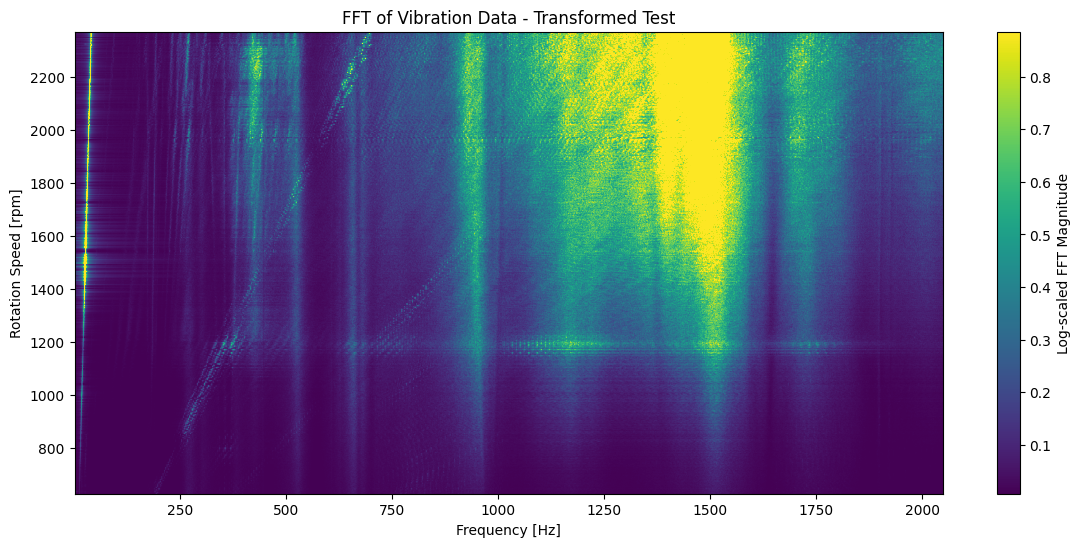

,fft_frequency,vibration_1_magnitude,vibration_2_magnitude,vibration_3_magnitude,rpm
count,6.590464e+06,6.590464e+06,6.590464e+06,6.590464e+06,6.590464e+06
mean,1.024500e+03,3.544855e-01,4.644803e-01,1.279989e-01,1.481815e+03
std,5.912067e+02,6.138504e-01,7.086115e-01,2.231240e-01,4.920425e+02
min,1.000000e+00,1.431051e-05,3.723914e-06,1.191485e-06,6.223728e+02
25%,5.127500e+02,3.832903e-02,4.015413e-02,2.442427e-02,1.054968e+03
50%,1.024500e+03,1.293303e-01,1.728410e-01,6.696210e-02,1.485139e+03
75%,1.536250e+03,4.007275e-01,5.980021e-01,1.614129e-01,1.909308e+03
max,2.048000e+03,1.761062e+01,2.051755e+01,1.778956e+01,2.376591e+03


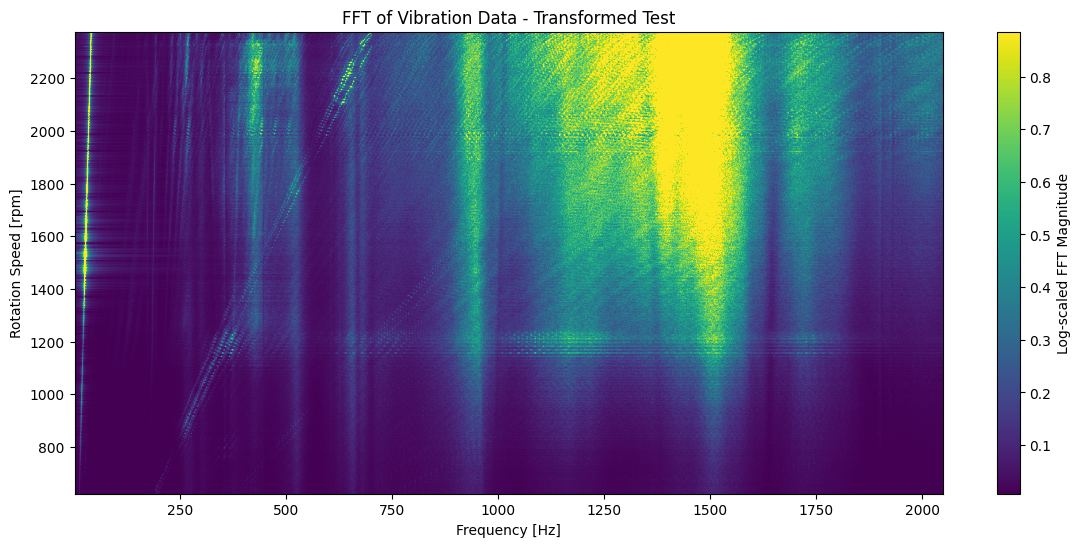

In [38]:
if SHOW:
    if not TESTING:

        # describe one random dataset for data validation
        display(measurement_cycles[CONTROL_INDEX].describe())
        vis.plot_fft_spectrogram(data_frame=measurement_cycles[CONTROL_INDEX],
                                    figsize=(14, 6))

    else:
        
        # program testing set
        for dataset in test_measurement_cycles:
            display(dataset.describe())
            vis.plot_fft_spectrogram(data_frame=dataset,
                                    figsize=(14, 6))

##### **Datenskalierung**
Vor der Eingabe in das NN werden die fourier-transformierten Daten skaliert. Mey et al. verwendeten hierfür "Robust Scaling" jeweils auf die Datenpunkte einer Sekunde. <br>
Das Programm nutzt hierzu den `RobustScaler` der Library Scikit-learn (Pedregosa et al., 2011). Der `RobustScaler` skaliert die Gesamtheit der $p=2048$ Fourier-Koeffizienten eines Fensters $\mathcal{A}$ mit einem Interquantilabstand (IRQ) zwischen dem 5%-Quantil $A_{0.05}$ und dem 95%-Quantil $A_{0.95}$ (vergl. Gl. 2).

$$A^*_k = \frac{A_k - \text{median}~{\mathcal{A}}}{A_{0.95} - A_{0.05}} \qquad \text{mit} \qquad \mathcal{A}=\{A_0,~\dots~A_k,~\dots~A_{p-1}\} \qquad \qquad (2)$$

In [39]:
if not TESTING:

    for index, dataset in enumerate(measurement_cycles):
        measurement_cycles[index] = pre.scale_robust(dataset, column_name="*magnitude*")

else:
    for index, dataset in enumerate(test_measurement_cycles):
        scaled_data = pre.scale_robust(dataset, column_name="*magnitude*")
        test_measurement_cycles[index] = scaled_data

KeyboardInterrupt: 

In [ ]:
if not TESTING:

    # describe one random dataset for data validation
    display(measurement_cycles[CONTROL_INDEX].describe())
    vis.plot_fft_spectrogram(data_frame=measurement_cycles[CONTROL_INDEX],
                                 figsize=(14, 6))

else:
    
    # program testing set
    for dataset in test_measurement_cycles:
        display(dataset.describe())
        vis.plot_fft_spectrogram(data_frame=dataset,
                                 figsize=(14, 6))

Abschließend speichert die Funtkion `save_dataset()` des Moduls `data_loading` die Datensätze in CSV-Dateien. Hierzu legt die Funktion im Ordner *data/* den Unterordner *processed/`UUID`* an. In diesem Ordner erstellt sie eine YAML-Datei, in der die `DataFrame.attrs` jedes im gleichen Ordner gespeicherten Datensatzes eingetragen werden.

In [ ]:
# saving the preprocessed data
if not TESTING:

    for dataset in measurement_cycles:
        dl.save_dataset(dataset, uuid=UUID)

else:
    for dataset in test_measurement_cycles:
        dl.save_dataset(dataset, uuid=UUID)


#### **Quellen**

##### **Literatur**
Harris, C. R., Millman, K. J., Van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., Wieser, E., Taylor, J., Berg, S., Smith, N. J., Kern, R., Picus, M., Hoyer, S., Van Kerkwijk, M. H., Brett, M., Haldane, A., Del Río, J. F., Wiebe, M., Peterson, P., . . . Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357–362. https://doi.org/10.1038/s41586-020-2649-2

Mey, O., Neudeck, W., Schneider, A. & Enge-Rosenblatt, O. (2020). Machine learning-based unbalance detection of a rotating shaft using vibration data. In 2020 25th IEEE International Conference on Emerging Technologies and Factory Automation (ETFA) (S. 1610–1617). IEEE. https://doi.org/10.1109/etfa46521.2020.9212000

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M. & Duchesnay, É. (2011). Scikit-learn: Machine Learning in Python. Journal Of Machine Learning Research, 12, 2825–2830. https://doi.org/10.5555/1953048.2078195

##### **Online**
Kuhlen, N., Beißner, L., Bergermann, T. & Wallrad, L. (2024). AI Gear Fault Detection (Version V1) [Computer Software]. https://github.com/ninakuhlen/ai-gear-fault-detection

Mey, O., Neudeck, W., Schneider, A. & Enge-Rosenblatt, O. (2022, 23. Februar). Vibration Analysis on Rotating Shaft. Kaggle. Abgerufen am 20. Oktober 2024, von https://www.kaggle.com/datasets/jishnukoliyadan/vibration-analysis-on-rotating-shaft

NumPy Developers. (o. D.). Discrete Fourier Transform (Numpy.FFT) — NUMPY v2.2 Manual. https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft

Scikit-learn Developers. (o. D.). RobustScaler. Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
